# Context Management Techniques in LangGraph

The workbook includes some of the techniques and tools available to manage context in LangGraph, including:
- Checkpointer
- Trimming Messages
- Summarising Messages
- Multi State Schemas
- Subgraphs

In [135]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.runnables import RunnableConfig
from typing import Annotated
from typing_extensions import TypedDict
from operator import add
from IPython.display import display, HTML, Image
from pydantic import BaseModel, Field

# Short Term Memory
 

## Checkpointer
This section will deomostrate how the checkpointer works.  The checkpoint persists the state of the graph in memory, so that it can be replayed.  A checkpoint can be associated with a thread, so LangGraph can maintain graphs in different states.


In [136]:
# Examples Reducer, to trace when calls happen
def my_add(a: int, b: int) -> int:
    print("Adding:", a, "+", b)
    return a + b

## Simple Checkpointer Example
This example simply writes text to the state (no LLM calls).  It will demonstrate how the checkpointer maintains graph state, and how it can be used to replay from a specific point in the graph.  This is very useful for development and debugging.

In [137]:
# These node functions simply write values to the state.  foo is a string, bar is a list of strings with a reducer that appends new values.
class State(BaseModel):
    foo: str
    bar: Annotated[list[str], my_add]

def node_a(state: State):
    print("Executing Node A")
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    print("Executing Node B")
    return {"foo": "b", "bar": ["b"]}



In [138]:
# create the workflow graph
workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)


## Creating and Using the Checkpointer
Below the checkpointer is created as an in memory checkpointer (will not be saved between runs - except in Jupyter).

The checkpointer is the passed to the graph when it is compiled.

In [147]:

checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)


### Graph Visualisation

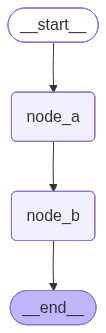

In [140]:
graph


### Invoking the Graph
A checkpointer needs to be associated with a thread when it is run.  To do this we pass the thread into the **config** property of the graph invocation.

Note that if you run the cell below multiple times, without recompiling the graph, it starts each new execution with the final state at the end of the previous execution.  The graph state has been persisted by the checkpointer.

In [148]:

config: RunnableConfig = {"configurable": {"thread_id": "1"}}
result = graph.invoke(State(foo="foo", bar=['z']), config)

print("Final State:", result)

Adding: [] + ['z']
Executing Node A
Adding: ['z'] + ['a']
Executing Node B
Adding: ['z', 'a'] + ['b']
Final State: {'foo': 'b', 'bar': ['z', 'a', 'b']}


## Observing State History
We can get the final state of the graph stored in the checkpointer with the get_state method, for a thread.

In [22]:
config = {"configurable": {"thread_id": "1"}}
graph.get_state(config)

StateSnapshot(values={'foo': 'b', 'bar': ['z', 'a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c3284-c463-6c9a-8002-420318b29f90'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-11-16T20:10:29.426493+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c3284-c463-6168-8001-eb1a03275f4a'}}, tasks=(), interrupts=())

The full history of the graph can see viewed using the get_state_history method.  Iterate over this to see see the state of the graph at each at each step in the graph traversal. 

In [142]:
states = []
for state in graph.get_state_history(config):
    states.append(state)
[print(state, "\n--------------------") for state in states]   

StateSnapshot(values={'foo': 'b', 'bar': ['z', 'a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c3cf0-4c59-6847-8002-8201850d27dc'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-11-17T16:03:55.419022+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c3cf0-4c54-6b2b-8001-4b280c0c71a0'}}, tasks=(), interrupts=()) 
--------------------
StateSnapshot(values={'foo': 'a', 'bar': ['z', 'a']}, next=('node_b',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c3cf0-4c54-6b2b-8001-4b280c0c71a0'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-11-17T16:03:55.417043+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c3cf0-4c45-6a9f-8000-7f87773528fd'}}, tasks=(PregelTask(id='5af6459f-1c7d-5698-f6dd-22c789089e79', name='node_b', path=('__pregel_pull', 'nod

[None, None, None, None]

This cell just reformats the list of states stored by the checkpointer to make it easier to read.

In [143]:
for state in reversed([state for state in graph.get_state_history(config)]):
    print("Step:", state.metadata['step'])
    print("Checkpoint ID:", state.config['configurable']['checkpoint_id'])
    print("Node:", state.tasks[0].name) if state.tasks else None
    print("values:", state.values)
    print("result:", state.tasks[0].result) if state.tasks else None
    # print(state)
    print("--------")
    

Step: -1
Checkpoint ID: 1f0c3cf0-4c0d-6791-bfff-8f817ecb842f
Node: __start__
values: {'bar': []}
result: {'foo': 'foo', 'bar': ['z']}
--------
Step: 0
Checkpoint ID: 1f0c3cf0-4c45-6a9f-8000-7f87773528fd
Node: node_a
values: {'foo': 'foo', 'bar': ['z']}
result: {'foo': 'a', 'bar': ['a']}
--------
Step: 1
Checkpoint ID: 1f0c3cf0-4c54-6b2b-8001-4b280c0c71a0
Node: node_b
values: {'foo': 'a', 'bar': ['z', 'a']}
result: {'foo': 'b', 'bar': ['b']}
--------
Step: 2
Checkpoint ID: 1f0c3cf0-4c59-6847-8002-8201850d27dc
values: {'foo': 'b', 'bar': ['z', 'a', 'b']}
--------


You can see there is a checkpoint ID for each step.  You can play the graph from any step using the checkpoint id.  To restart the graph from a specific step add the checkpoint_id to the configuration and then pass 'None' for the state, when invoking the graph.  The graph will continue a new run from the step you've selected, with all the state as it was for the first run.

This is very useful when developing and debugging, or for application where you want long running state over multiple runs.

Note that the checkpoint id will be different for every run, so you will need to copy one of the checkpoint IDs from above into the config below.  For instance, if you take the Id for step 1, you will just see step 2 run, with the state pass to step 1 the same as it was in the previous run.

In [145]:

config = {"configurable": {"thread_id": "1" }, "checkpoint_ns": '',  "checkpoint_id": "1f0c3cf0-4c45-6a9f-8000-7f87773528fd"}
result = graph.invoke(None, config)
print("Final State:", result)

Executing Node A
Adding: ['z'] + ['a']
Executing Node B
Adding: ['z', 'a'] + ['b']
Final State: {'foo': 'b', 'bar': ['z', 'a', 'b']}


## MESSAGE MANAGEMENT
For long running 'conversations', between LLM and tools (or if there are large messages) then the context window can start to full up, and make it increasingly difficult for the LLM to be able to correctly read all the content.

In cases where it is necessary to have these long running conversations then there are techniques to reduce the size of the context window:
- Triming
- Summarization
- Deletion

### TRIMING MESSAGES
Triming means removing messages from the messages.  You can define the criteria for removal, but typically you will want older message removed and want to ensure the sequence of Human message, AI message, tool message is maintained.  Optionally (but normally) you will want to retain the system message.  You can specify the max number of tokens and the function will try to maintain that, while ensure the message sequence is maintained. 

In [149]:
# trim messages
from langchain_core.messages.utils import (
    trim_messages,  
    count_tokens_approximately  
)

# import systemmessage, humanmessage, aimessage, toolmessage
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    ToolMessage
)

## Sample Message History

In [150]:
#  This is a dummy conversation with multiple messages to demonstrate trimming
messages = [
    SystemMessage(content="You are an assistant expert in writing SQL. You can take SQL queries and optimize them for performance."),
    HumanMessage(content="Optimize this SQL query: SELECT * FROM users WHERE age > 30 AND status = 'active';"),
    AIMessage(content="Optimize the SQL query to improve performance by adding appropriate indexes and avoiding SELECT *.", additional_kwargs={}),
    HumanMessage(content="Optimize this SQL query: SELECT name, email FROM customers WHERE country = 'US' AND signup_date > '2022-01-01';"),
    AIMessage(content="To optimize the SQL query, consider adding an index on the country and signup_date columns.", additional_kwargs={}),
    HumanMessage(content="Optimize this SQL query: SELECT order_id, total_amount FROM orders WHERE order_date BETWEEN '2023-01-01' AND '2023-12-31' AND status = 'completed';"),
    AIMessage(content="To optimize the SQL query, create a composite index on order_date and status columns.", additional_kwargs={}),
]

### trim_messsages class from LangChain
Pass a messsages list to the utility to trim the list.

The number of tokens to be kept can be specified, the utility keeps whole messages.  You can also specify if you want to keep the System message and decide which message type to start and end on, to keep the correct sequence of messages after trimming.

In [155]:
# Trim utility provided by LangChain to limit messages based on token count
trimmed_messages = trim_messages(
    messages, 
    max_tokens=200,
    token_counter=count_tokens_approximately,
    strategy="last",
    # start_on="human",
    include_system=True
)

In [154]:
for  m in trimmed_messages:
    print(m.content)

You are an assistant expert in writing SQL. You can take SQL queries and optimize them for performance.
Optimize this SQL query: SELECT order_id, total_amount FROM orders WHERE order_date BETWEEN '2023-01-01' AND '2023-12-31' AND status = 'completed';
To optimize the SQL query, create a composite index on order_date and status columns.


In [156]:
from typing import Any, TypedDict

from langchain.chat_models import init_chat_model
from langchain.messages import AnyMessage, RemoveMessage
from langgraph.types import Overwrite
from langchain_core.messages.utils import count_tokens_approximately
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.checkpoint.memory import InMemorySaver
from dotenv import load_dotenv

load_dotenv()

True

In [157]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

In [162]:
def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is a summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above."
            " Make sure you retain information about the user."
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [163]:
def call_model(state: State):  
    response = model.invoke( [HumanMessage(content=state['summary'])] + state["messages"])
    return {"messages": [response]}

In [164]:
checkpointer = InMemorySaver()
builder = StateGraph(State)
builder.add_node(call_model)
builder.add_node("summarize", summarize_conversation)  
builder.add_edge(START, "summarize")
builder.add_edge("summarize", "call_model")
builder.add_edge("call_model", END)
graph = builder.compile(checkpointer=checkpointer)

# Invoke the graph
config = {"configurable": {"thread_id": "1"}}
res1 = graph.invoke({"messages": "hi, my name is bob", "summary": ""}, config)
res2 = graph.invoke({"messages": "write a short poem about cats", "summary": res1["summary"]}, config)
res3 = graph.invoke({"messages": "now do the same but for dogs", "summary": res2["summary"]}, config)
final_response = graph.invoke({"messages": "what's my name?", "summary": res3["summary"]}, config)

print("Final Response:", final_response["messages"][-1])

Final Response: content="You've introduced yourself as **Bob**." additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'} id='lc_run--4ffec721-0273-495b-ad48-39cc4555a118-0' usage_metadata={'input_tokens': 135, 'output_tokens': 9, 'total_tokens': 144, 'input_token_details': {'cache_read': 0}}


In [115]:
final_response

{'messages': [AIMessage(content="Okay, Bob! Here's a poem about dogs, inspired by your prompt:\n\nA happy bark, a wagging tail,\nLoyalty's promise, that will not fail.\nA wet nose nudges, a joyful bound,\nThe best of friends, that can be found.\nWith ears that perk and eyes so bright,\nThey fill our days with pure delight.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--9619bac3-20d7-4140-b8ed-3b0bbaead998-0', usage_metadata={'input_tokens': 145, 'output_tokens': 80, 'total_tokens': 225, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='dd4125d2-a2c9-4cc4-a7f6-50c6d8c468d1'),
  AIMessage(content="You've been calling me Bob, so I've been addressing you as Bob.", additional_kwargs={}, response

## MULTIPLE STATE SCHEMAS
We have been defining state schema with all the graphs.  We can add any property to our state schema and use it as a way to carry data between nodes (and conditional edges).  We can use this as a way to carry data between nodes and then select which attributes we will use in the state for the next node.

Usually the same state schema (class definition) will pass through all nodes.  However, it is possible to define different input and output schemas for a graph, such that schema information may only exist in one part of the graph.
 

In [165]:
class InputState(TypedDict):
    user_input: str

class OutputState(TypedDict):
    graph_output: str

class OverallState(TypedDict):
    foo: str
    user_input: str
    graph_output: str

class PrivateState(TypedDict):
    bar: str

def node_1(state: InputState) -> OverallState:
    # Write to OverallState
    return {"foo": state["user_input"] + " name"}

def node_2(state: OverallState) -> PrivateState:
    # Read from OverallState, write to PrivateState
    return {"bar": state["foo"] + " is"}

def node_3(state: PrivateState) -> OutputState:
    # Read from PrivateState, write to OutputState
    return {"graph_output": state["bar"] + " Lance"}

builder = StateGraph(OverallState,input_schema=InputState,output_schema=OutputState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# add checkpointer
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)
# create config
config = {"configurable": {"thread_id": "1"}}
graph.invoke({"user_input":"My"}, config=config)
# {'graph_output': 'My name is Lance'}

{'graph_output': 'My name is Lance'}

In [123]:
for state in reversed([state for state in graph.get_state_history(config)]):
    print("Step:", state.metadata['step'])
    print("Checkpoint ID:", state.config['configurable']['checkpoint_id'])
    print("Node:", state.tasks[0].name) if state.tasks else None
    print("values:", state.values)
    print("result:", state.tasks[0].result) if state.tasks else None
    # print(state)
    print("--------")

Step: -1
Checkpoint ID: 1f0c3390-0498-6b79-bfff-02aa23433c33
Node: __start__
values: {}
result: {'user_input': 'My'}
--------
Step: 0
Checkpoint ID: 1f0c3390-049a-65a8-8000-6310151bb7df
Node: node_1
values: {'user_input': 'My'}
result: {'foo': 'My name'}
--------
Step: 1
Checkpoint ID: 1f0c3390-049b-6941-8001-fa1722b2f9c1
Node: node_2
values: {'foo': 'My name', 'user_input': 'My'}
result: {'bar': 'My name is'}
--------
Step: 2
Checkpoint ID: 1f0c3390-049c-6b16-8002-bdfd6e1b1856
Node: node_3
values: {'foo': 'My name', 'user_input': 'My', 'bar': 'My name is'}
result: {'graph_output': 'My name is Lance'}
--------
Step: 3
Checkpoint ID: 1f0c3390-049d-6415-8003-4ff1b2f47d4b
values: {'foo': 'My name', 'user_input': 'My', 'graph_output': 'My name is Lance', 'bar': 'My name is'}
--------


# SUBGRAPHS
A subgraph enables one graph to call another graph.  Normally we consider the calling graph to be the parent and the invoked sub graph to be the child.  We can decompose this pattern as much as required.

Subgraphs are a very power technique that allows us to create separate graphs for a particular task.  While they are performing that task they can maintain a local state required for the task.  The graph can return the result of the task back to the parent graph.  This makes it much easier to compartmentalize context to a particular task such that other parts of the graph do not need to share irrelevant context.

Key to the interaction between parent and child graphs is how they share state.  There are two models for this:
- Shared State
- Separate State
  
In shared state, the parent graph state is passed to the child graph to populate with additional information.  Alternatively, a node can create and invoke the subgraph with a different state.  The node is then responsible for explicitly read and returning values from the parent state to the sub graph (note that a node can only call one subgraph).

## SubGraph with Separate State
This simple example (without any LLM calls) shows how state is used between a parent and child subgraph.

Note that the node calling the child graph needs to manage all state properties between the two graphs.

In [166]:
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START

# Define subgraph
class SubgraphState(TypedDict):
    # note that none of these keys are shared with the parent graph state
    bar: str
    baz: str

def subgraph_node_1(state: SubgraphState):
    return {"baz": "baz"}

def subgraph_node_2(state: SubgraphState):
    return {"bar": state["bar"] + state["baz"]}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()

# Define parent graph
class ParentState(TypedDict):
    foo: str

def node_1(state: ParentState):
    return {"foo": "hi! " + state["foo"]}

def node_2(state: ParentState):
    # Transform the state to the subgraph state
    response = subgraph.invoke({"bar": state["foo"]})
    # Transform response back to the parent state
    return {"foo": response["bar"]}


builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
graph = builder.compile()

for chunk in graph.stream({"foo": "foo"}, subgraphs=True):
    print(chunk)

((), {'node_1': {'foo': 'hi! foo'}})
(('node_2:2f7a9e68-0588-2e64-7b01-43c5b44fe757',), {'subgraph_node_1': {'baz': 'baz'}})
(('node_2:2f7a9e68-0588-2e64-7b01-43c5b44fe757',), {'subgraph_node_2': {'bar': 'hi! foobaz'}})
((), {'node_2': {'foo': 'hi! foobaz'}})


## Multi Level Subgraph with Separate States
The pattern of parent and child graphs can be extended to any level of depth, allowing for further decomposition of flow and separations of concern and state with the agentic application.

In [167]:
# Grandchild graph
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START, END

class GrandChildState(TypedDict):
    my_grandchild_key: str

def grandchild_1(state: GrandChildState) -> GrandChildState:
    # NOTE: child or parent keys will not be accessible here
    return {"my_grandchild_key": state["my_grandchild_key"] + ", how are you"}


grandchild = StateGraph(GrandChildState)
grandchild.add_node("grandchild_1", grandchild_1)

grandchild.add_edge(START, "grandchild_1")
grandchild.add_edge("grandchild_1", END)

grandchild_graph = grandchild.compile()

# Child graph
class ChildState(TypedDict):
    my_child_key: str

def call_grandchild_graph(state: ChildState) -> ChildState:
    # NOTE: parent or grandchild keys won't be accessible here
    grandchild_graph_input = {"my_grandchild_key": state["my_child_key"]}
    grandchild_graph_output = grandchild_graph.invoke(grandchild_graph_input)
    return {"my_child_key": grandchild_graph_output["my_grandchild_key"] + " today?"}

child = StateGraph(ChildState)
# We're passing a function here instead of just compiled graph (`grandchild_graph`)
child.add_node("child_1", call_grandchild_graph)
child.add_edge(START, "child_1")
child.add_edge("child_1", END)
child_graph = child.compile()

# Parent graph
class ParentState(TypedDict):
    my_key: str

def parent_1(state: ParentState) -> ParentState:
    # NOTE: child or grandchild keys won't be accessible here
    return {"my_key": "hi " + state["my_key"]}

def parent_2(state: ParentState) -> ParentState:
    return {"my_key": state["my_key"] + " bye!"}

def call_child_graph(state: ParentState) -> ParentState:
    child_graph_input = {"my_child_key": state["my_key"]}
    child_graph_output = child_graph.invoke(child_graph_input)
    return {"my_key": child_graph_output["my_child_key"]}

parent = StateGraph(ParentState)
parent.add_node("parent_1", parent_1)
# We're passing a function here instead of just a compiled graph (`child_graph`)
parent.add_node("child", call_child_graph)
parent.add_node("parent_2", parent_2)

parent.add_edge(START, "parent_1")
parent.add_edge("parent_1", "child")
parent.add_edge("child", "parent_2")
parent.add_edge("parent_2", END)

parent_graph = parent.compile()

for chunk in parent_graph.stream({"my_key": "Bob"}, subgraphs=True):
    print(chunk)

((), {'parent_1': {'my_key': 'hi Bob'}})
(('child:b9883265-8363-e281-b597-7f6827cddfa6', 'child_1:9c98878d-7413-12a1-42f6-3218cae37bcf'), {'grandchild_1': {'my_grandchild_key': 'hi Bob, how are you'}})
(('child:b9883265-8363-e281-b597-7f6827cddfa6',), {'child_1': {'my_child_key': 'hi Bob, how are you today?'}})
((), {'child': {'my_key': 'hi Bob, how are you today?'}})
((), {'parent_2': {'my_key': 'hi Bob, how are you today? bye!'}})


## Shared State SubGraph

In [169]:
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START

# Define subgraph
class SubgraphState(TypedDict):
    foo: str  # shared with parent graph state
    bar: str  # private to SubgraphState

def subgraph_node_1(state: SubgraphState):
    return {"bar": "bar"}

def subgraph_node_2(state: SubgraphState):
    # note that this node is using a state key ('bar') that is only available in the subgraph
    # and is sending update on the shared state key ('foo')
    return {"foo": state["foo"] + state["bar"]}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()

# Define parent graph
class ParentState(TypedDict):
    foo: str

def node_1(state: ParentState):
    return {"foo": "hi! " + state["foo"]}

builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", subgraph)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
graph = builder.compile()

for chunk in graph.stream({"foo": "foo"}):
    print(chunk)

{'node_1': {'foo': 'hi! foo'}}
{'node_2': {'foo': 'hi! foobar'}}
